Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.

Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.

Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [1]:
import os
import pandas as pd
from env import user_name, host, password 

def get_connection(db):
    '''
    Creates a connection URL
    '''
    return f'mysql+pymysql://{user_name}:{password}@{host}/{db}'


def new_curriculum_logs_data():
    '''
    Returns curriculum logs into a dataframe
    '''
    sql_query = '''select * from logs join cohorts on cohorts.id=logs.cohort_id'''
    df = pd.read_sql(sql_query, get_connection('curriculum_logs'))
    return df 

def get_curriculum_logs_data():
    '''get connection, returns curriculum log's logs table into a dataframe and creates a csv for us'''
    if os.path.isfile('curriculum-access.csv'):
        df = pd.read_csv('curriculum-access.csv')
    else:
        df = new_curriculum_logs_data()
        df.to_csv('curriculum-access.csv', index=False)
    return df

def new_grocery_data():
    '''
    Returns curriculum logs into a dataframe
    '''
    sql_query = '''select * from grocery_customers'''
    df = pd.read_sql(sql_query, get_connection('grocery_db'))
    return df    

def get_grocery_data():
    '''get connection, returns grocery_customers into a dataframe and creates a csv for us'''
    if os.path.isfile('grocery_db.csv'):
        df = pd.read_csv('grocery_db.csv')
    else:
        df = new_grocery_data()
        df.to_csv('grocery_db.csv', index=False)
    return df

In [2]:
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = get_grocery_data()

In [4]:
df.head()

,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0,2,3,12669,9656,7561,214,2674,1338
1,1,2,3,7057,9810,9568,1762,3293,1776
2,2,2,3,6353,8808,7684,2405,3516,7844
3,3,1,3,13265,1196,4221,6404,507,1788
4,4,2,3,22615,5410,7198,3915,1777,5185


In [5]:
#Set customer id as the idnex
df = df.set_index('customer_id')

In [6]:
#Rename our columns
df.columns = ['channel','region','fresh','milk','grocery','frozen','soap','pepperoni']

In [7]:
df

,channel,region,fresh,milk,grocery,frozen,soap,pepperoni
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867


In [8]:
frozen_soap_pepperoni = df[['frozen','soap','pepperoni']]

In [9]:
frozen_soap_pepperoni.head()

,frozen,soap,pepperoni
customer_id,,,
0,214,2674,1338
1,1762,3293,1776
2,2405,3516,7844
3,6404,507,1788
4,3915,1777,5185


In [10]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(frozen_soap_pepperoni)

# Use the scaler
frozen_soap_pepperoni = scaler.transform(frozen_soap_pepperoni)
frozen_soap_pepperoni

array([[0.0031063 , 0.0654272 , 0.02784731],
       [0.02854842, 0.08058985, 0.03698373],
       [0.03911643, 0.08605232, 0.16355861],
       ...,
       [0.00677142, 0.36346267, 0.03888194],
       [0.01664914, 0.00404174, 0.04426366],
       [0.00065742, 0.01161082, 0.00102211]])

In [11]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(frozen_soap_pepperoni)

DBSCAN(eps=0.1, min_samples=20)

In [12]:
# scaled value columns back onto the dataframe
columns = ["frozen", "soap", "pepperoni"]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(frozen_soap_pepperoni, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])
df.head()

,channel,region,fresh,milk,grocery,frozen,soap,pepperoni,Scaled_frozen,Scaled_soap,Scaled_pepperoni
0,2,3,12669,9656,7561,214,2674,1338,0.003106,0.065427,0.027847
1,2,3,7057,9810,9568,1762,3293,1776,0.028548,0.080590,0.036984
2,2,3,6353,8808,7684,2405,3516,7844,0.039116,0.086052,0.163559
3,1,3,13265,1196,4221,6404,507,1788,0.104842,0.012346,0.037234
4,2,3,22615,5410,7198,3915,1777,5185,0.063934,0.043455,0.108093


In [13]:
# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers
df['labels'] = dbsc.labels_
df.labels.value_counts()

 0    423
-1     17
Name: labels, dtype: int64

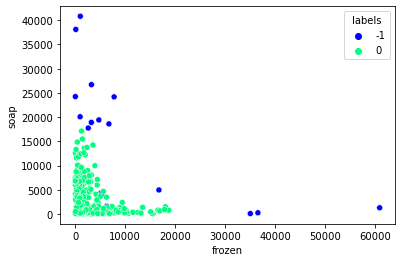

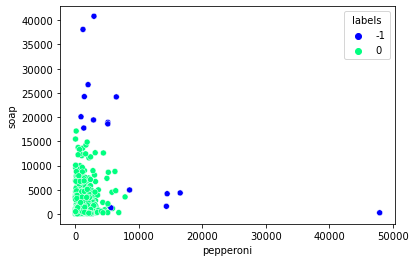

In [14]:
sns.scatterplot(df.frozen, df.soap, hue=df.labels, palette='winter')
plt.show()

sns.scatterplot(df.pepperoni, df.soap, hue=df.labels, palette='winter')
plt.show()

Text(0.5, 0, 'Pepperoni')

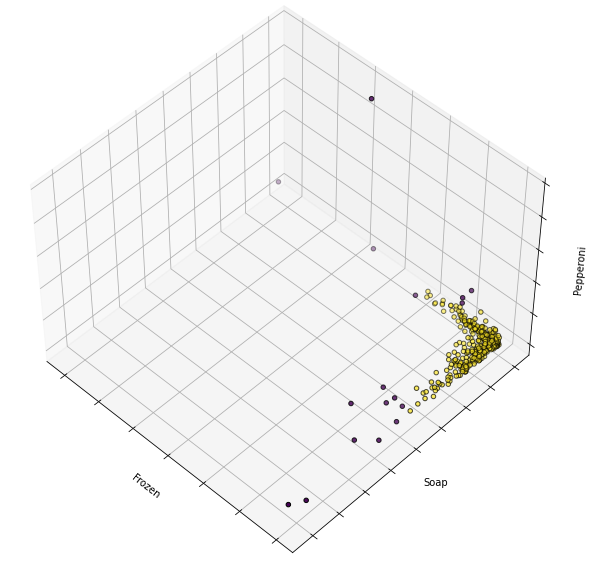

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.frozen, df.soap, df.pepperoni,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Frozen')
ax.set_ylabel('Soap')
ax.set_zlabel('Pepperoni')

In [16]:
df = pd.read_csv('logsql.csv')

In [17]:
#df = df.dropna()

In [18]:
df.head()

,date,date.1,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1
1,2018-01-26,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1
2,2018-01-26,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1
3,2018-01-26,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1
4,2018-01-26,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,NaN,2


In [19]:
df = df.head(1000)

In [20]:
df.date = pd.to_datetime(df.date)

In [21]:
df.shape

(1000, 16)

In [22]:
columns = ["user_id","program_id"]

In [23]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
#scaler.fit(codeup)

# Use the scaler
codeup = scaler.fit_transform(df[columns])
codeup

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [24]:
type(codeup)

numpy.ndarray

In [25]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(codeup)

DBSCAN(eps=0.1, min_samples=20)

In [26]:
# Now, let's add the scaled value columns back onto the dataframe
scaled_columns = ["Scaled_" + column for column in columns]

In [27]:
# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(codeup, columns=scaled_columns)

In [28]:
scaled_df

,Scaled_user_id,Scaled_program_id
0,0.000000,0.0
1,0.000000,0.0
2,0.000000,0.0
3,0.000000,0.0
4,0.018519,1.0
...,...,...
995,0.592593,1.0
996,0.592593,1.0
997,1.000000,1.0
998,1.000000,1.0


In [29]:
# Merge the scaled and non-scaled values into one dataframe
#df = df.merge(scaled_df, on= df.index, how ='left')
#df = df.drop(columns=['key_0'])
#df = df.drop(columns=['date.1'])

In [30]:
df['labels'] = dbsc.labels_
df.labels.value_counts()

 0    901
 1     68
-1     31
Name: labels, dtype: int64

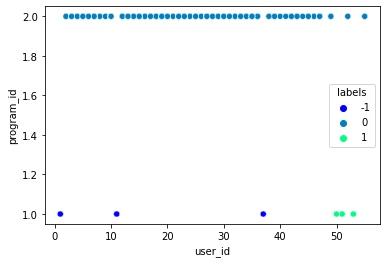

In [31]:
sns.scatterplot(df.user_id, df.program_id, hue=df.labels, palette='winter')
plt.show()

In [32]:
def new_zillow_data():
    '''
    Returns zillow into a dataframe
    '''
    sql_query =''' 
    SELECT * 
        FROM predictions_2017 pred
        LEFT JOIN properties_2017 USING(parcelid)
        LEFT JOIN airconditioningtype USING(airconditioningtypeid)
        LEFT JOIN architecturalstyletype USING(architecturalstyletypeid)
        LEFT JOIN buildingclasstype USING(buildingclasstypeid)
        LEFT JOIN heatingorsystemtype USING(heatingorsystemtypeid)
        LEFT JOIN propertylandusetype USING(propertylandusetypeid)
        LEFT JOIN storytype USING(storytypeid)
        LEFT JOIN typeconstructiontype USING(typeconstructiontypeid)
        WHERE pred.transactiondate LIKE '2017%%'
        AND latitude IS NOT NULL
        AND longitude IS NOT NULL
        AND propertylandusetypeid IN (261, 263, 264, 265, 266, 268, 273, 275, 276, 279);  
    '''
    df = pd.read_sql(sql_query, get_connection('zillow'))
    return df 

def get_zillow_data():
    '''
    get connection, returns zillow into a dataframe and creates a csv for us
    '''
    if os.path.isfile('zillow.csv'):
        df = pd.read_csv('zillow.csv', index_col=0)
    else:
        df = new_zillow_data()
        df.to_csv('zillow.csv')
    return df

In [33]:
from collections import Counter
from datetime import date
def handle_missing_values(df, prop_required_column=0.5 , prop_required_row=0.75):
    '''
    This function takes in a pandas dataframe, default proportion of required columns (set to 50%) and proprtion of required rows (set to 75%).
    It drops any rows or columns that contain null values more than the threshold specified from the original dataframe and returns that dataframe.
    
    Prior to returning that data, it will print statistics and list counts/names of removed columns/row counts 
    '''
    original_cols = df.columns.to_list()
    original_rows = df.shape[0]
    threshold = int(round(prop_required_column * len(df.index), 0))
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_required_row * len(df.columns), 0))
    df = df.dropna(axis=0, thresh=threshold)
    remaining_cols = df.columns.to_list()
    remaining_rows = df.shape[0]
    dropped_col_count = len(original_cols) - len(remaining_cols)
    dropped_cols = list((Counter(original_cols) - Counter(remaining_cols)).elements())
    print(f'The following {dropped_col_count} columns were dropped because they were missing more than {prop_required_column * 100}% of data: \n{dropped_cols}\n')
    dropped_rows = original_rows - remaining_rows
    print(f'{dropped_rows} rows were dropped because they were missing more than {prop_required_row * 100}% of data')
    return df


def prep_zillow(df):
    '''
    This function takes in a pandas dataframe, removes duplicate rows and columns, 
    handles missing values, drops columns with nulls beyond threshold specified, removes properties 
    witn 0 beds and 0 baths as well as any with 0 baths or square footage of 0.
    '''
    
    # drop duplicate columns
    df = df.loc[:,~df.columns.duplicated()]

    # check for duplicates 
    num_dups = df.duplicated().sum()
    # if we found duplicate rows, we will remove them, log accordingly and proceed
    if num_dups > 0:
        print(f'There are {num_dups} duplicate rows in your dataset - these will be dropped.')
        print ('----------------')
        # remove the duplicates found
        df = df.drop_duplicates()

    else:
        # otherwise, we log that there are no dupes, and proceed with our process
        print(f'There are no duplicate rows in your dataset.')
        print('----------------')

    # dropping cols/rows where more than half of the values are null
    df = handle_missing_values(df, prop_required_column = .6, prop_required_row = .75)

    # keep only properties with more than 0 beds and 0 baths
    df = df[(df.bedroomcnt > 0) & (df.bathroomcnt > 0)]
    
    # # remove properties with 0 baths
    df = df[df.bathroomcnt > 0]

    # # keep only properties with square footage greater than 0
    df = df[df.calculatedfinishedsquarefeet > 0]

    # Creating new feature age_of_home
    # find median yearbuilt 
    median_year = df.yearbuilt.median()

    # replace the missing values in the yearbuilt column with the above calculated median value
    df['yearbuilt'] = df['yearbuilt'].replace(np.NaN, median_year)

    # encode yearbuilt as age of home in years as an integer
    df['age_of_home'] = (date.today().year - df.yearbuilt).astype(int)

    #----------------------#
    #  One hot encoding    #
    #----------------------#

    # encode categorical variable: county to numeric
    dummy_df=pd.get_dummies(df['fips'], dummy_na=False, 
                            drop_first=False)

    # rename columns that have been one hot encoded
    dummy_df = dummy_df.rename(columns={6037.0: 'LA_county', 6059.0: 'orange_county', 6111.0: 'ventura_county'})  

    # join dummy df to original df
    df = pd.concat([df, dummy_df], axis=1)

    # return cleaned dataframe
    return df


In [34]:
#It looks like python is interpreting the % as a printf-like format character. Try using %%?
#And it works
df = get_zillow_data()

In [35]:
df = prep_zillow(df)

There are no duplicate rows in your dataset.
----------------
The following 34 columns were dropped because they were missing more than 60.0% of data: 
['typeconstructiontypeid', 'storytypeid', 'buildingclasstypeid', 'architecturalstyletypeid', 'airconditioningtypeid', 'basementsqft', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'regionidneighborhood', 'threequarterbathnbr', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear', 'airconditioningdesc', 'architecturalstyledesc', 'buildingclassdesc', 'storydesc', 'typeconstructiondesc']

141 rows were dropped because they were missing more than 75.0% of data


In [36]:
df.head()

,propertylandusetypeid,heatingorsystemtypeid,parcelid,id,logerror,transactiondate,id.1,bathroomcnt,bedroomcnt,buildingqualitytypeid,...,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,heatingorsystemdesc,propertylandusedesc,age_of_home,LA_county,orange_county,ventura_county
0,261.0,NaN,14297519,0,0.025595,2017-01-01,1727539,3.5,4.0,NaN,...,2016.0,537569.0,11013.72,6.059063e+13,NaN,Single Family Residential,24,0,1,0
1,261.0,NaN,17052889,1,0.055619,2017-01-01,1387261,1.0,2.0,NaN,...,2016.0,376000.0,5672.48,6.111001e+13,NaN,Single Family Residential,55,0,0,1
2,261.0,NaN,14186244,2,0.005383,2017-01-01,11677,2.0,3.0,NaN,...,2016.0,479489.0,6488.30,6.059022e+13,NaN,Single Family Residential,60,0,1,0
3,261.0,2.0,12177905,3,-0.103410,2017-01-01,2288172,3.0,4.0,8.0,...,2016.0,36225.0,1777.51,6.037300e+13,Central,Single Family Residential,52,1,0,0
4,266.0,2.0,10887214,4,0.006940,2017-01-01,1970746,3.0,3.0,8.0,...,2016.0,45726.0,1533.89,6.037124e+13,Central,Condominium,58,1,0,0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71769 entries, 0 to 72256
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         71769 non-null  float64
 1   heatingorsystemtypeid         46439 non-null  float64
 2   parcelid                      71769 non-null  int64  
 3   id                            71769 non-null  int64  
 4   logerror                      71769 non-null  float64
 5   transactiondate               71769 non-null  object 
 6   id.1                          71769 non-null  int64  
 7   bathroomcnt                   71769 non-null  float64
 8   bedroomcnt                    71769 non-null  float64
 9   buildingqualitytypeid         44876 non-null  float64
 10  calculatedbathnbr             71754 non-null  float64
 11  calculatedfinishedsquarefeet  71769 non-null  float64
 12  finishedsquarefeet12          71576 non-null  float64
 13  f

In [38]:
beds_sqft = df[['bedroomcnt','calculatedfinishedsquarefeet']]
beds_sqft

,bedroomcnt,calculatedfinishedsquarefeet
0,4.0,3100.0
1,2.0,1465.0
2,3.0,1243.0
3,4.0,2376.0
4,3.0,1312.0
...,...,...
72252,3.0,1741.0
72253,2.0,1286.0
72254,4.0,1612.0
72255,3.0,1032.0


In [39]:
# Make
scaler = MinMaxScaler()

# Fit
scaler.fit(beds_sqft)

# Use
beds_sqft = scaler.transform(beds_sqft)
beds_sqft

array([[0.23076923, 0.13537218],
       [0.07692308, 0.06029297],
       [0.15384615, 0.05009873],
       ...,
       [0.23076923, 0.06704321],
       [0.15384615, 0.04040961],
       [0.15384615, 0.07393121]])

In [40]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(beds_sqft)

DBSCAN(eps=0.1, min_samples=20)

In [41]:
columns = ['bedroomcnt','calculatedfinishedsquarefeet']
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(beds_sqft, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
#df = df.drop(columns=['key_0'])
df.head()

,key_0,propertylandusetypeid,heatingorsystemtypeid,parcelid,id,logerror,transactiondate,id.1,bathroomcnt,bedroomcnt,...,taxamount,censustractandblock,heatingorsystemdesc,propertylandusedesc,age_of_home,LA_county,orange_county,ventura_county,Scaled_bedroomcnt,Scaled_calculatedfinishedsquarefeet
0,0,261.0,NaN,14297519,0,0.025595,2017-01-01,1727539,3.5,4.0,...,11013.72,6.059063e+13,NaN,Single Family Residential,24,0,1,0,0.230769,0.135372
1,1,261.0,NaN,17052889,1,0.055619,2017-01-01,1387261,1.0,2.0,...,5672.48,6.111001e+13,NaN,Single Family Residential,55,0,0,1,0.076923,0.060293
2,2,261.0,NaN,14186244,2,0.005383,2017-01-01,11677,2.0,3.0,...,6488.30,6.059022e+13,NaN,Single Family Residential,60,0,1,0,0.153846,0.050099
3,3,261.0,2.0,12177905,3,-0.103410,2017-01-01,2288172,3.0,4.0,...,1777.51,6.037300e+13,Central,Single Family Residential,52,1,0,0,0.230769,0.102126
4,4,266.0,2.0,10887214,4,0.006940,2017-01-01,1970746,3.0,3.0,...,1533.89,6.037124e+13,Central,Condominium,58,1,0,0,0.153846,0.053267


In [42]:
df['labels'] = dbsc.labels_
df.labels.value_counts()

 0    71757
-1       12
Name: labels, dtype: int64

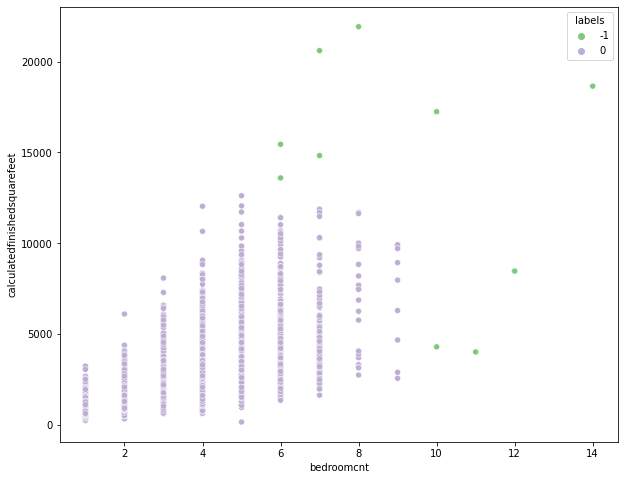

In [44]:
plt.figure(figsize=(10,8))
sns.scatterplot(df.bedroomcnt, df.calculatedfinishedsquarefeet, hue=df.labels, palette='Accent')
plt.show()